In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

df = pd.read_csv("/content/all_stocks_5yr.csv")
# Convert 'date' to datetime first
df['date'] = pd.to_datetime(df['date'])

# Now drop rows with missing values (this will drop rows where ANY column is NaN)
df.dropna(inplace=True)

# Set 'date' as index
df.set_index('date', inplace=True)

# Filter for one stock (e.g., Apple)
df_aapl = df[df['Name'] == 'AAPL'].copy()

# Drop the 'Name' column before resampling, as it's not numeric
df_aapl.drop('Name', axis=1, inplace=True)

# Optional: Resample (monthly average)
df_aapl = df_aapl.resample('M').mean()

# Normalize (optional)
scaler = MinMaxScaler()
df_aapl[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(df_aapl[['open', 'high', 'low', 'close', 'volume']])

/tmp/ipython-input-1-2711194089.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_aapl = df_aapl.resample('M').mean()


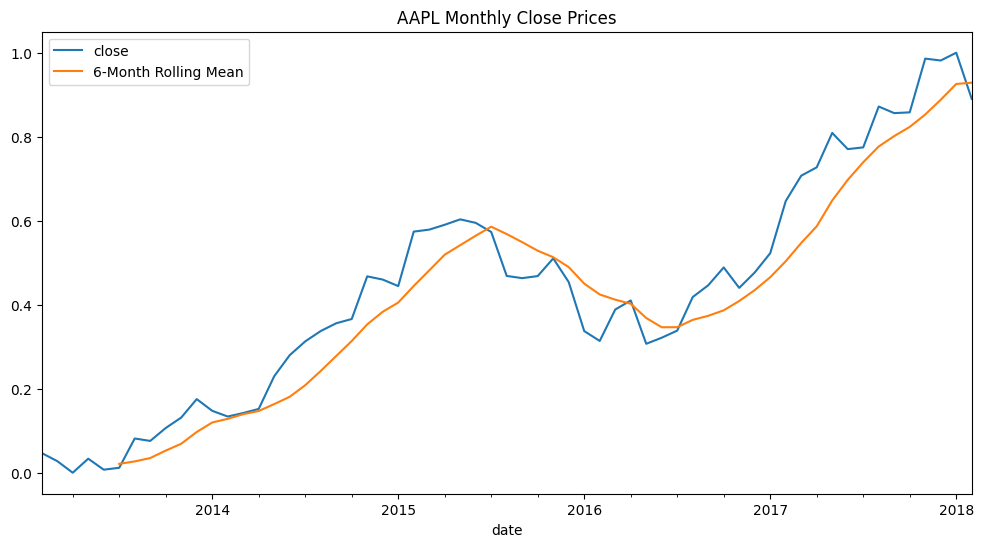

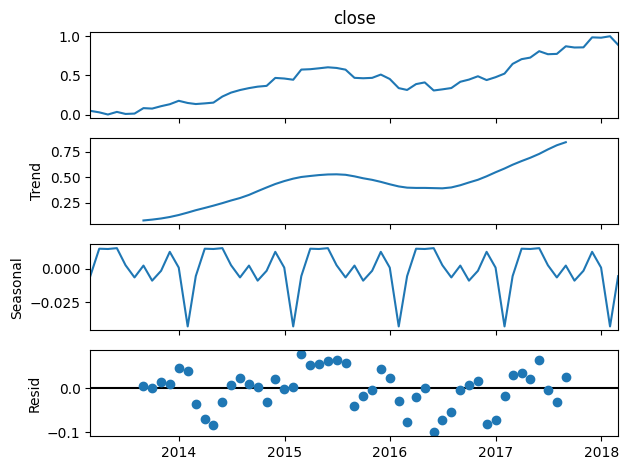

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Line plot
df_aapl['close'].plot(figsize=(12, 6), title='AAPL Monthly Close Prices')
plt.grid()

# Rolling Mean
df_aapl['close'].rolling(window=6).mean().plot(label='6-Month Rolling Mean')
plt.legend()
plt.show()

# Seasonal Decomposition
decompose_result = seasonal_decompose(df_aapl['close'], model='additive', period=12)
decompose_result.plot()
plt.show()


In [3]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_aapl['close'], order=(5, 1, 0))
model_fit = model.fit()
forecast_arima = model_fit.forecast(steps=12)


In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_aapl['close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = model.fit()
forecast_sarima = sarima_fit.forecast(steps=12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4mzu3by5/o_y1ith9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4mzu3by5/ta0damlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28811', 'data', 'file=/tmp/tmp4mzu3by5/o_y1ith9.json', 'init=/tmp/tmp4mzu3by5/ta0damlz.json', 'output', 'file=/tmp/tmp4mzu3by5/prophet_modello1fbkz0/prophet_model-20250715073718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:37:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

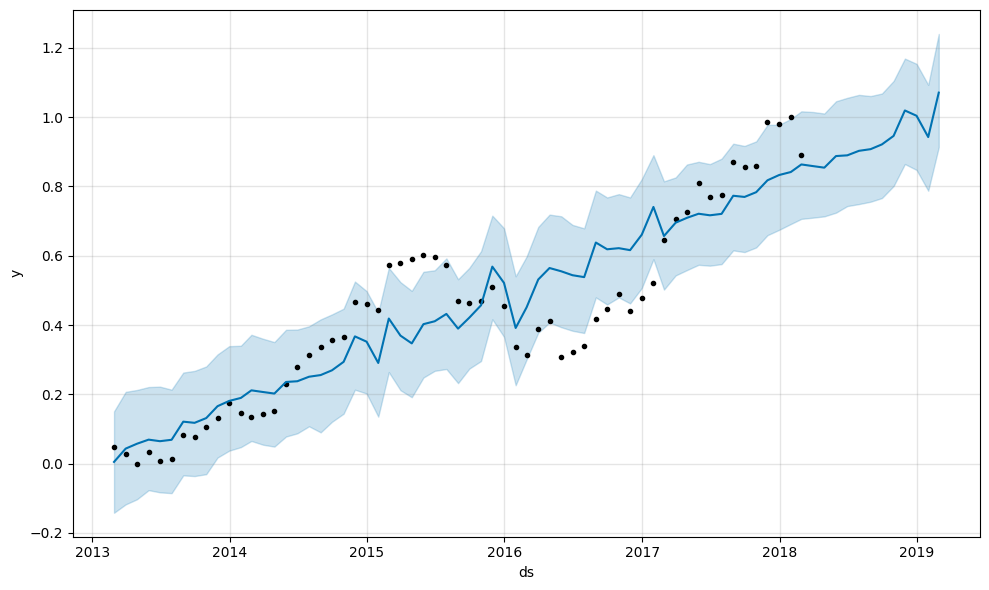

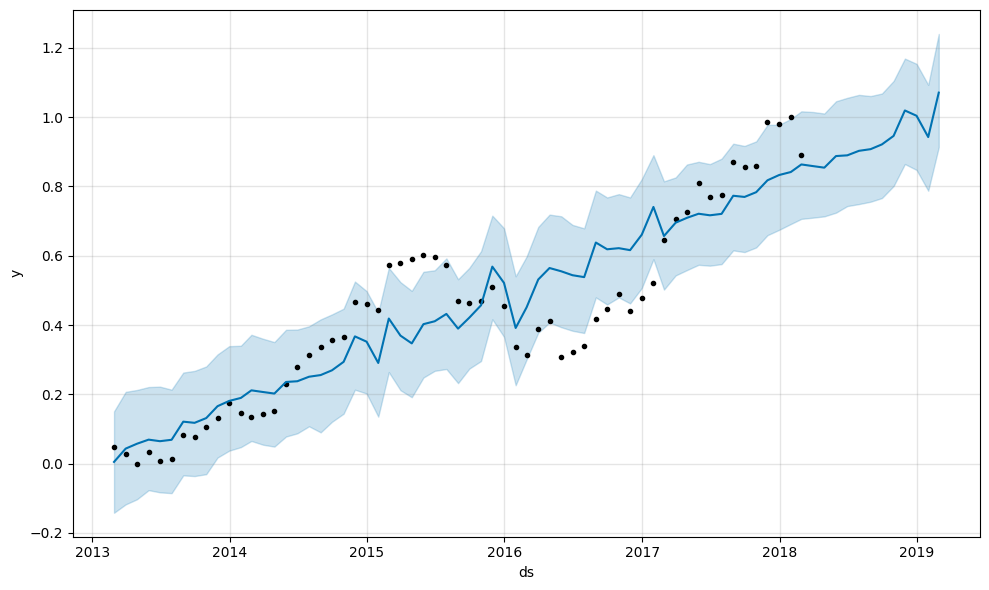

In [5]:
from prophet import Prophet

df_prophet = df_aapl.reset_index()[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=12, freq='M')
forecast_prophet = model.predict(future)
model.plot(forecast_prophet)


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert to supervised format
data = df_aapl['close'].values.reshape(-1, 1)
X, y = [], []
for i in range(60, len(data)):
    X.append(data[i-60:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)

# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.8159
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7308
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6517
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5777
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5081
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4422
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3794
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3194
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2621
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2075
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1561
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1087
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0668
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0324
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0088
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    print("R2 Score:", r2_score(y_true, y_pred))

# Example usage:
# evaluate(y_true=actual_data, y_pred=forecast_arima)


In [8]:
import plotly.graph_objects as go
import pandas as pd # Import pandas to handle date index

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_aapl.index, y=df_aapl['close'], name='Actual'))

# --- Added code starts here ---

# Assuming you want to plot the Prophet forecast for simplicity.
# You can choose any of the generated forecasts (ARIMA, SARIMA, Prophet)
# and adapt the code to get the index and values.

# Extract the dates (ds) and forecast values (yhat) from the Prophet forecast DataFrame
forecast_index = forecast_prophet['ds']
forecast_values = forecast_prophet['yhat']

# --- Added code ends here ---

fig.add_trace(go.Scatter(x=forecast_index, y=forecast_values, name='Forecast'))
fig.update_layout(title='AAPL Stock Forecast', xaxis_title='Date', yaxis_title='Close Price')
fig.show()

In [9]:
pip install ydata-profiling


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=f96b69a473f6550a4ae8ebca8daf3454a4a72de469f503188395a74e4b9439b3
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [10]:
from ydata_profiling import ProfileReport

In [11]:
profile = ProfileReport(df, title='Stock Data Profiling Report', explorative=True)

In [12]:
profile.to_notebook_iframe()


Output hidden; open in https://colab.research.google.com to view.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4mzu3by5/t90pnmrf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4mzu3by5/4hc3d87s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11668', 'data', 'file=/tmp/tmp4mzu3by5/t90pnmrf.json', 'init=/tmp/tmp4mzu3by5/4hc3d87s.json', 'output', 'file=/tmp/tmp4mzu3by5/prophet_modelqubkf9rh/prophet_model-20250715073835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:38:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


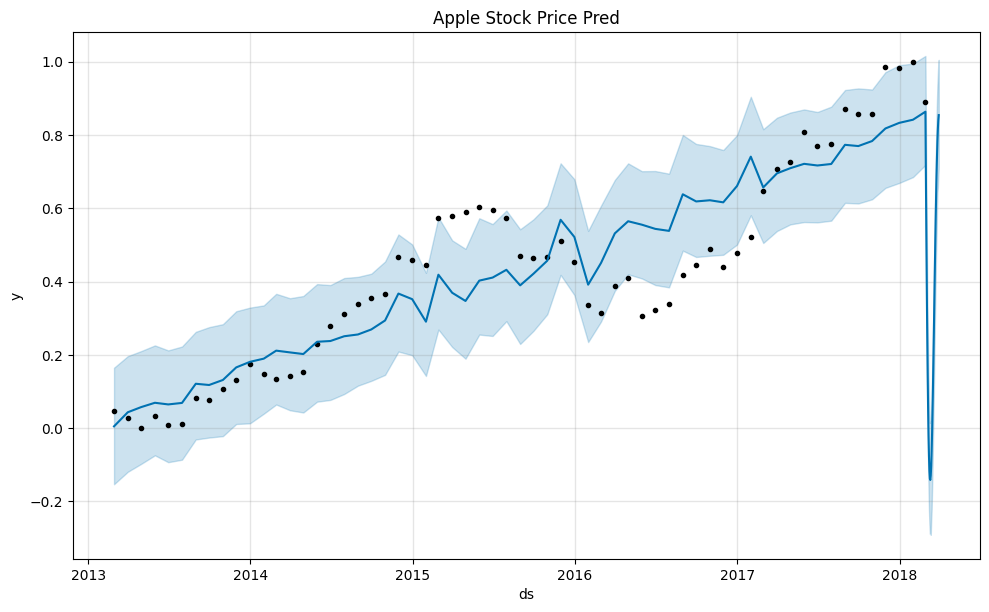

           ds      yhat  yhat_lower  yhat_upper
0  2013-02-28  0.004748   -0.153248    0.164666
1  2013-03-31  0.043206   -0.119287    0.196311
2  2013-04-30  0.057250   -0.097736    0.210113
3  2013-05-31  0.069099   -0.074334    0.225638
4  2013-06-30  0.064594   -0.093053    0.212017
..        ...       ...         ...         ...
86 2018-03-26  0.740610    0.592490    0.893744
87 2018-03-27  0.783063    0.644164    0.936840
88 2018-03-28  0.816333    0.657388    0.966744
89 2018-03-29  0.840063    0.687538    0.996680
90 2018-03-30  0.854129    0.710574    1.004861

[91 rows x 4 columns]


In [14]:
model = Prophet()
# Use the df_prophet DataFrame which has 'ds' and 'y' columns
model.fit(df_prophet)

# Define how many future days you want to predict
periods = 30  # for 30 days into the future

# Create a future dataframe
future_dates = model.make_future_dataframe(periods=periods)

# Forecast future data
forecast = model.predict(future_dates)
model.plot(forecast)
plt.title('Apple Stock Price Pred')
plt.show()
# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

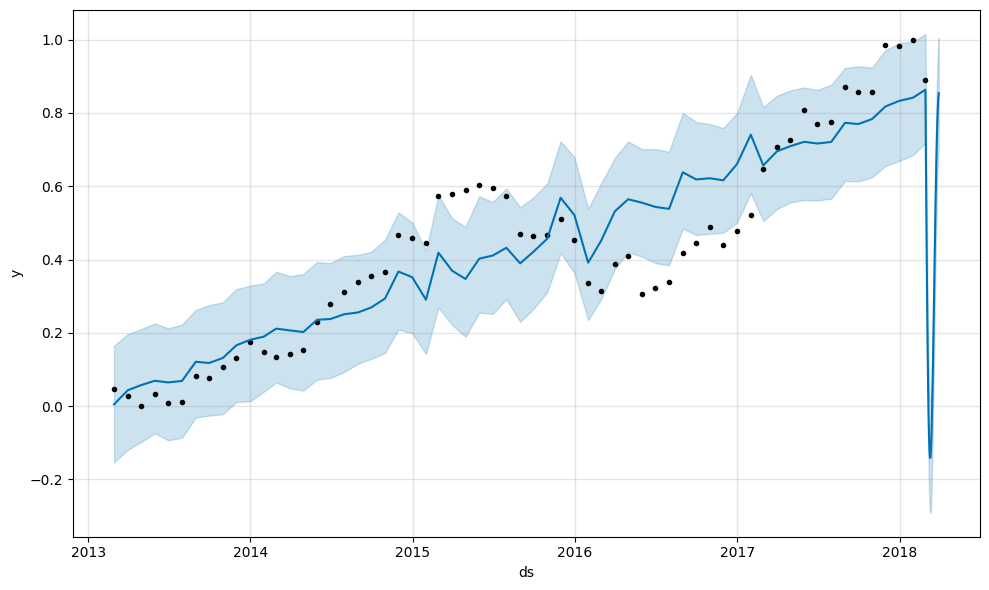

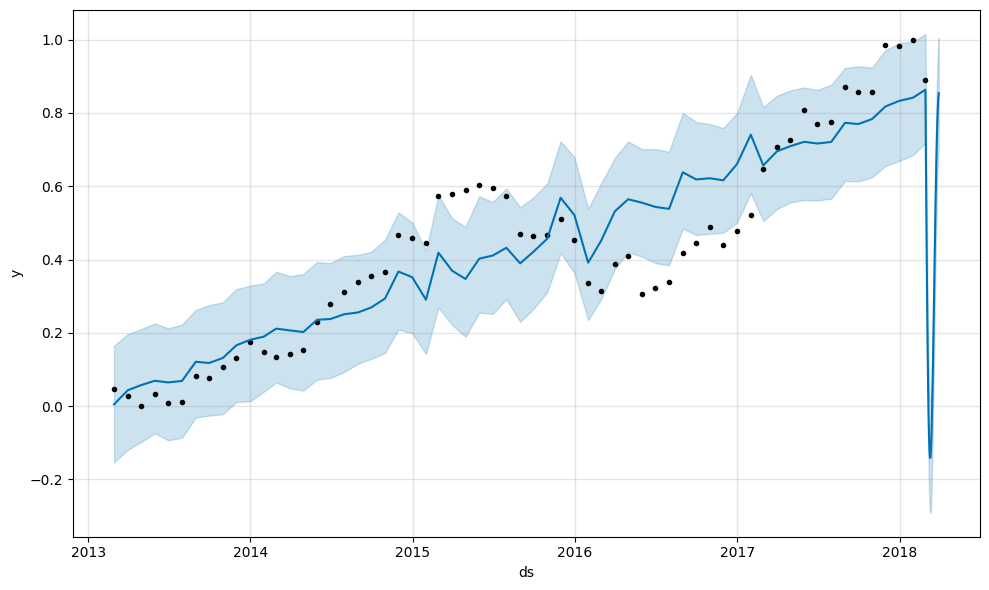

In [15]:
model.plot(forecast)

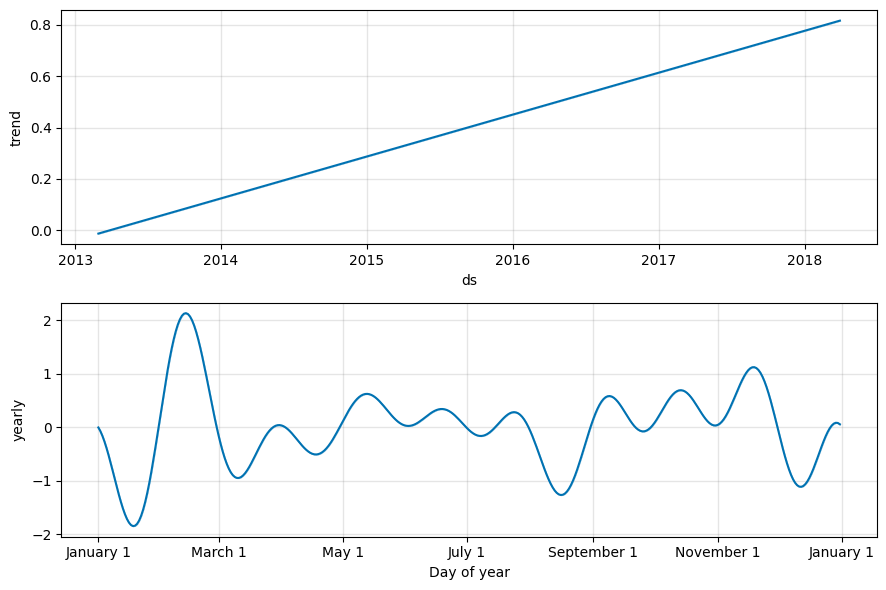

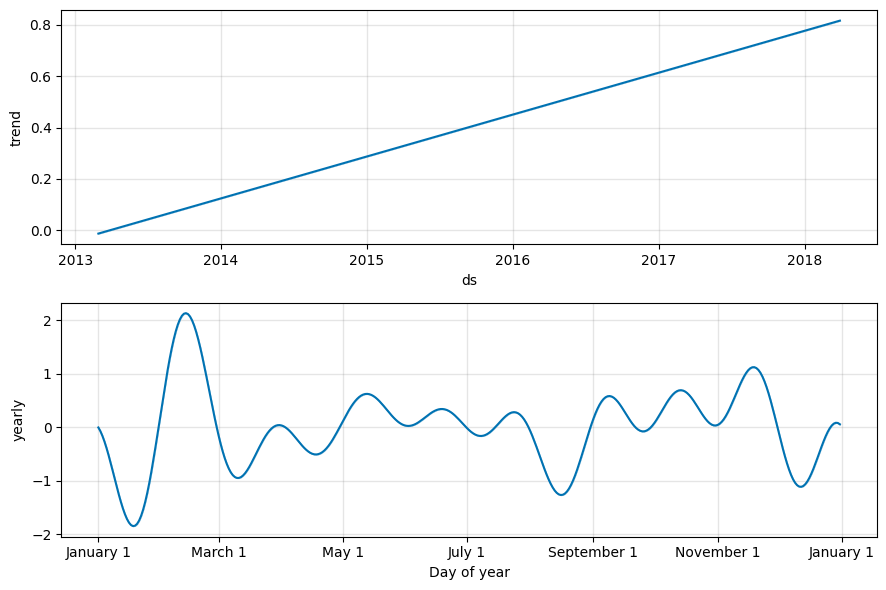

In [16]:
model.plot_components(forecast)


In [18]:
df_10 = pd.DataFrame()
df_10['close'] = df['close'].rolling(window=10).mean()
df_20 = pd.DataFrame()
df_20['close'] = df['close'].rolling(window=20).mean()
df_30 = pd.DataFrame()
df_30['close'] = df['close'].rolling(window=30).mean()
df_40 = pd.DataFrame()
df_40['close'] = df['close'].rolling(window=40).mean()

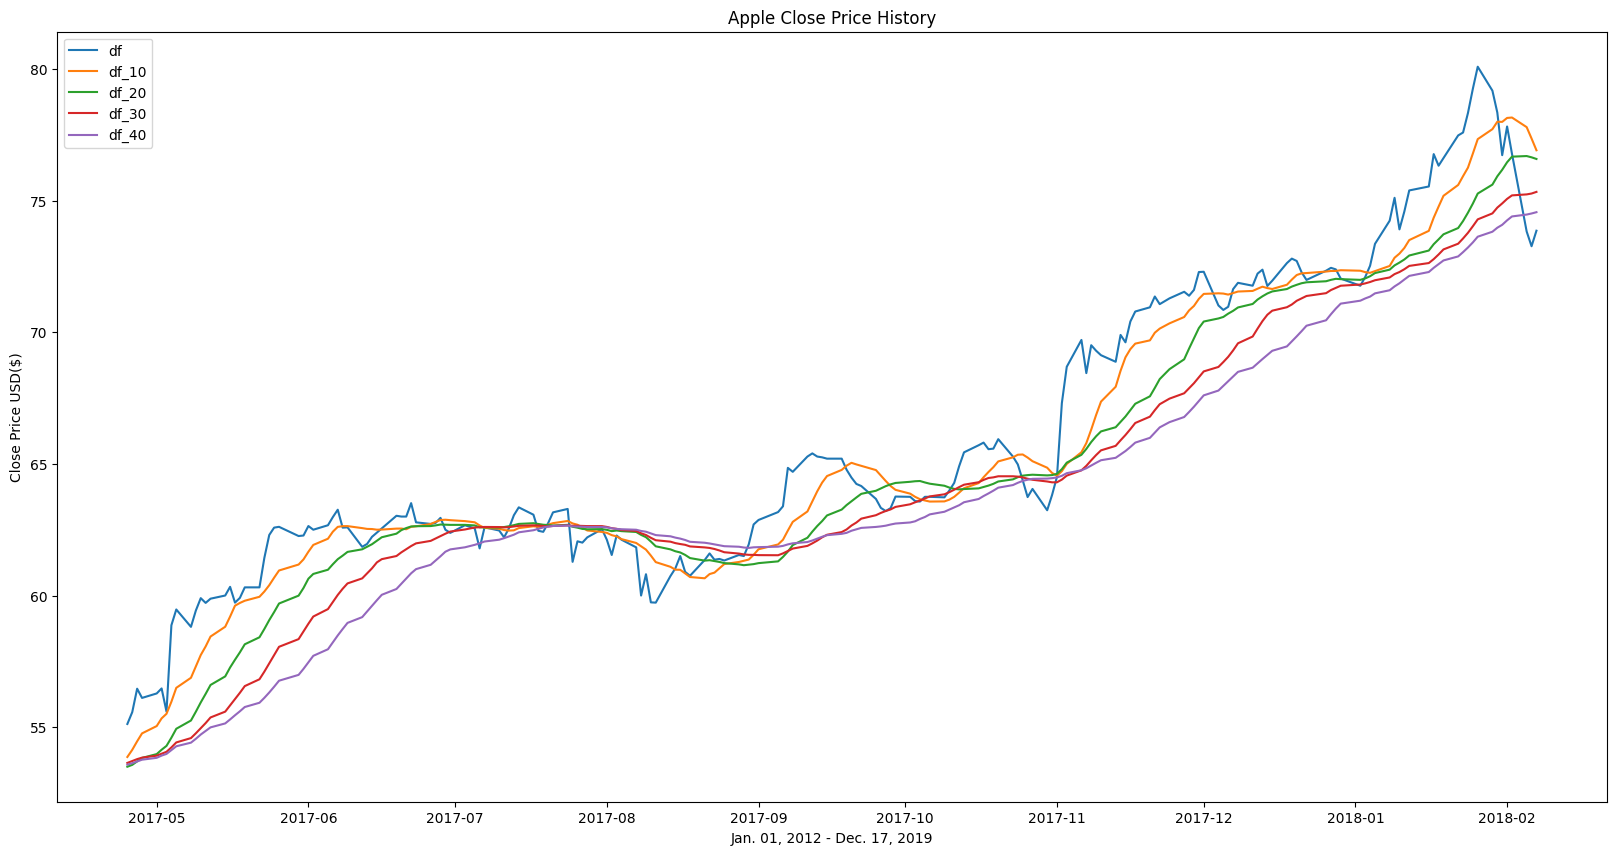

In [19]:
plt.figure(figsize=(20,10))
plt.plot(df['close'].tail(200), label='df')
plt.plot(df_10['close'].tail(200), label='df_10')
plt.plot(df_20['close'].tail(200), label='df_20')
plt.plot(df_30['close'].tail(200), label='df_30')
plt.plot(df_40['close'].tail(200), label='df_40')
plt.title('Apple Close Price History')
plt.xlabel('Jan. 01, 2012 - Dec. 17, 2019')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()
